In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns

from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import minmax_scale
from scipy.stats import probplot, moment
from sklearn.metrics import mean_absolute_error
from pandas.plotting import autocorrelation_plot


In [2]:
def plot_correlogram(x, lags=None, title=None):
    lags = min(10, int(len(x) / 5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title="Time Series")
    x.rolling(21).mean().plot(ax=axes[0][0], c="k", lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f"Q-Stat: {np.max(q_p):>8.4f}\nADF_p_value: {adfuller(x)[1]:>11.4f}"
    axes[0][0].text(x=0.02, y=0.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f"Mean: {mean:>12.4f}\nSD: {np.sqrt(var):>16.4f}\nSkew: {skew:12.4f}\nKurtosis:{kurtosis:9.4f}"
    axes[0][1].text(x=0.02, y=0.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel("Lag")
    axes[1][1].set_xlabel("Lag")
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)

In [3]:
# refer to https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html on regression{“c”,”ct”,”ctt”,”n”}
# we set to n because 2nd order implies no constant trend, no time dependent trend
def test_unit_root(df):
    p_value = df.apply(lambda x: adfuller(x, regression="n")[1]).to_dict()
    lag_used = df.apply(lambda x: adfuller(x, regression="n")[2]).to_dict()

    return {"p_value": p_value, "lag_used": lag_used}

In [4]:
start_date = pd.to_datetime("2019-04-01")
end_date = pd.to_datetime("2022-04-01")
print(f"{start_date} & {end_date}")

2019-04-01 00:00:00 & 2022-04-01 00:00:00


## DATA PREPROCESSING ##

In [5]:
# this is our target
y_CME3MSOFR = pd.read_csv(f"../data/CME3MSOFR.csv")
y_CME3MSOFR = y_CME3MSOFR.dropna(axis="columns")
y_CME3MSOFR.drop(columns=["dd", "mm", "yyyy"], inplace=True)
y_CME3MSOFR.columns = ["date", "rate_CME3MSOFR"]
y_CME3MSOFR["date"] = pd.to_datetime(y_CME3MSOFR["date"])
# flip it so that first row
y_CME3MSOFR = y_CME3MSOFR.iloc[::-1]
print(y_CME3MSOFR.head())
print(test_unit_root(y_CME3MSOFR))

           date  rate_CME3MSOFR
1198 2019-01-03          2.4328
1197 2019-01-04          2.4296
1196 2019-01-07          2.4276
1195 2019-01-08          2.4298
1194 2019-01-09          2.4390
{'p_value': {'date': 0.9991478433392181, 'rate_CME3MSOFR': 0.8579828990092411}, 'lag_used': {'date': 19, 'rate_CME3MSOFR': 19}}


In [6]:
start_date = y_CME3MSOFR.iloc[0][0]
end_date = y_CME3MSOFR.iloc[-1][0]
print(f"{start_date} & {end_date}")

2019-01-03 00:00:00 & 2023-11-21 00:00:00


In [7]:
# this is our feature -
# 3MSOFRFuture
x_3MSOFRFuture = pd.read_csv(f"../data/3MSOFRFuture.csv")
x_3MSOFRFuture = x_3MSOFRFuture.dropna(axis="columns")
x_3MSOFRFuture.drop(columns=["dd", "mm", "yyyy"], inplace=True)
x_3MSOFRFuture.columns = ["date", "price_3MSOFRFuture"]
x_3MSOFRFuture["date"] = pd.to_datetime(x_3MSOFRFuture["date"])
# flip it so that first row
x_3MSOFRFuture = x_3MSOFRFuture.iloc[::-1]
print(x_3MSOFRFuture.head())
print(test_unit_root(x_3MSOFRFuture))

           date  price_3MSOFRFuture
1246 2018-12-14              97.370
1245 2018-12-17              97.405
1244 2018-12-18              97.455
1243 2018-12-19              97.460
1242 2018-12-20              97.470
{'p_value': {'date': 1.0, 'price_3MSOFRFuture': 0.20085157870907655}, 'lag_used': {'date': 22, 'price_3MSOFRFuture': 19}}


In [8]:
# USD3MLIBOR
x_USD3MLIBOR = pd.read_csv(f"../data/USD3MLIBOR.csv")
x_USD3MLIBOR = x_USD3MLIBOR.dropna(axis="columns")
x_USD3MLIBOR.drop(columns=["dd", "mm", "yyyy"], inplace=True)
x_USD3MLIBOR.columns = ["date", "rate_USD3MLIBOR"]
x_USD3MLIBOR["date"] = pd.to_datetime(x_USD3MLIBOR["date"])
# flip it so that first row
x_USD3MLIBOR = x_USD3MLIBOR.iloc[::-1]
print(x_USD3MLIBOR.head())
print(test_unit_root(x_USD3MLIBOR))

           date  rate_USD3MLIBOR
1258 2018-11-26          2.70681
1257 2018-11-27          2.70600
1256 2018-11-28          2.70663
1255 2018-11-29          2.73813
1254 2018-11-30          2.73613
{'p_value': {'date': 1.0, 'rate_USD3MLIBOR': 0.9699682964678737}, 'lag_used': {'date': 18, 'rate_USD3MLIBOR': 7}}


In [9]:
# USD3MLIBOR
x_USTbill3M = pd.read_csv(f"../data/USTbill3M.csv")
x_USTbill3M = x_USTbill3M.dropna(axis="columns")
x_USTbill3M.columns = ["date", "rate_USTbill3M"]
x_USTbill3M["date"] = pd.to_datetime(x_USTbill3M["date"])
# no need flip, already in correct order
print(x_USTbill3M.head())
print(test_unit_root(x_USTbill3M))

        date  rate_USTbill3M
0 2018-11-26          2.3775
1 2018-11-27          2.3771
2 2018-11-28          2.3704
3 2018-11-29          2.3616
4 2018-11-30          2.3654
{'p_value': {'date': 1.0, 'rate_USTbill3M': 0.903527608288582}, 'lag_used': {'date': 21, 'rate_USTbill3M': 21}}


In [10]:
# USD3MOIS this is weird data
x_USD3MOIS = pd.read_csv(f"../data/USD3MOIS.csv")
x_USD3MOIS.columns = ["date", "bid", "ask"]
x_USD3MOIS["date"] = pd.to_datetime(x_USD3MOIS["date"])
x_USD3MOIS["mid_USD3MOIS"] = 0.5 * (x_USD3MOIS["bid"] + x_USD3MOIS["ask"])
# flip it so that first row
x_USD3MOIS = x_USD3MOIS.iloc[::-1]
print(x_USD3MOIS.head())
print(test_unit_root(x_USD3MOIS))

           date    bid    ask  mid_USD3MOIS
1515 2018-01-02  1.429  1.449         1.439
1514 2018-01-03  1.429  1.459         1.444
1513 2018-01-04  1.439  1.469         1.454
1512 2018-01-05  1.439  1.469         1.454
1511 2018-01-08  1.447  1.467         1.457
{'p_value': {'date': 0.9999557878897856, 'bid': 0.9004720611599424, 'ask': 0.923203927767669, 'mid_USD3MOIS': 0.9193785681559442}, 'lag_used': {'date': 24, 'bid': 23, 'ask': 24, 'mid_USD3MOIS': 24}}


In [11]:
variable_names = [var_name for var_name in globals().keys() if "x_" in var_name]
print(variable_names)

['minmax_scale', 'x_3MSOFRFuture', 'x_USD3MLIBOR', 'x_USTbill3M', 'x_USD3MOIS']


In [12]:
to_concat = [x_3MSOFRFuture, x_USD3MLIBOR, x_USTbill3M, x_USD3MOIS]
df_concat = y_CME3MSOFR
for frames in to_concat:
    df_concat = pd.merge(df_concat, frames, on="date", how="left")
    print(df_concat.isna().sum())
df_concat.drop(columns=["bid", "ask"], inplace=True)

date                  0
rate_CME3MSOFR        0
price_3MSOFRFuture    0
dtype: int64
date                   0
rate_CME3MSOFR         0
price_3MSOFRFuture     0
rate_USD3MLIBOR       27
dtype: int64
date                   0
rate_CME3MSOFR         0
price_3MSOFRFuture     0
rate_USD3MLIBOR       27
rate_USTbill3M         1
dtype: int64
date                   0
rate_CME3MSOFR         0
price_3MSOFRFuture     0
rate_USD3MLIBOR       27
rate_USTbill3M         1
bid                    0
ask                    0
mid_USD3MOIS           0
dtype: int64


In [13]:
rows_with_na = df_concat[df_concat.isna().any(axis=1)]
rows_with_na

,date,rate_CME3MSOFR,price_3MSOFRFuture,rate_USD3MLIBOR,rate_USTbill3M,mid_USD3MOIS
73,2019-04-22,2.44250,97.900,NaN,2.4262,2.4160
83,2019-05-06,2.42910,97.975,NaN,2.4119,2.3880
161,2019-08-26,1.91500,98.930,NaN,1.9374,1.8760
244,2019-12-26,1.58750,98.480,NaN,1.5673,1.5670
317,2020-04-13,0.06640,99.705,NaN,0.2277,0.0820
335,2020-05-08,0.05240,99.885,NaN,0.1129,0.0490
414,2020-08-31,0.06980,99.935,NaN,0.1003,0.0760
494,2020-12-28,0.06700,99.770,NaN,0.0886,0.0800
560,2021-04-02,0.01960,99.160,NaN,0.0145,0.0680
561,2021-04-05,0.01960,99.195,NaN,0.0163,0.0690


In [14]:
# for NA values, we will use forward filling, i hope its ok
df_concat = df_concat.fillna(method="ffill")
rows_with_na = df_concat[df_concat.isna().any(axis=1)]
rows_with_na

,date,rate_CME3MSOFR,price_3MSOFRFuture,rate_USD3MLIBOR,rate_USTbill3M,mid_USD3MOIS


In [15]:
# reindex and fill date, my concern i think this is due to weekends
idx = pd.date_range(start_date, end_date)
print(idx)
df_concat = df_concat.set_index("date")
df_concat = df_concat.reindex(idx)
df_concat = df_concat.fillna(method="ffill")

DatetimeIndex(['2019-01-03', '2019-01-04', '2019-01-05', '2019-01-06',
               '2019-01-07', '2019-01-08', '2019-01-09', '2019-01-10',
               '2019-01-11', '2019-01-12',
               ...
               '2023-11-12', '2023-11-13', '2023-11-14', '2023-11-15',
               '2023-11-16', '2023-11-17', '2023-11-18', '2023-11-19',
               '2023-11-20', '2023-11-21'],
              dtype='datetime64[ns]', length=1784, freq='D')


In [16]:
df_concat.head(10)

,rate_CME3MSOFR,price_3MSOFRFuture,rate_USD3MLIBOR,rate_USTbill3M,mid_USD3MOIS
2019-01-03,2.4328,97.835,2.79500,2.3919,2.393
2019-01-04,2.4296,97.770,2.80388,2.4058,2.404
2019-01-05,2.4296,97.770,2.80388,2.4058,2.404
2019-01-06,2.4296,97.770,2.80388,2.4058,2.404
2019-01-07,2.4276,97.725,2.79681,2.4127,2.407
2019-01-08,2.4298,97.655,2.78250,2.4243,2.415
2019-01-09,2.4390,97.665,2.79888,2.4213,2.410
2019-01-10,2.4481,97.660,2.79694,2.4232,2.413
2019-01-11,2.4448,97.675,2.78731,2.4222,2.410
2019-01-12,2.4448,97.675,2.78731,2.4222,2.410


In [17]:
df_concat.tail(10)

,rate_CME3MSOFR,price_3MSOFRFuture,rate_USD3MLIBOR,rate_USTbill3M,mid_USD3MOIS
2023-11-12,5.37103,94.6525,5.63925,5.4182,5.3868
2023-11-13,5.37764,94.6525,5.64133,5.4245,5.3940
2023-11-14,5.37972,94.6500,5.65182,5.4014,5.3649
2023-11-15,5.39021,94.6500,5.63098,5.4061,5.3686
2023-11-16,5.36937,94.6500,5.62871,5.3972,5.3662
2023-11-17,5.36710,94.6525,5.62854,5.3969,5.3696
2023-11-18,5.36710,94.6525,5.62854,5.3969,5.3696
2023-11-19,5.36710,94.6525,5.62854,5.3969,5.3696
2023-11-20,5.36710,94.6525,5.62854,5.3969,5.3696
2023-11-21,5.37151,94.6500,5.63963,5.3999,5.3770


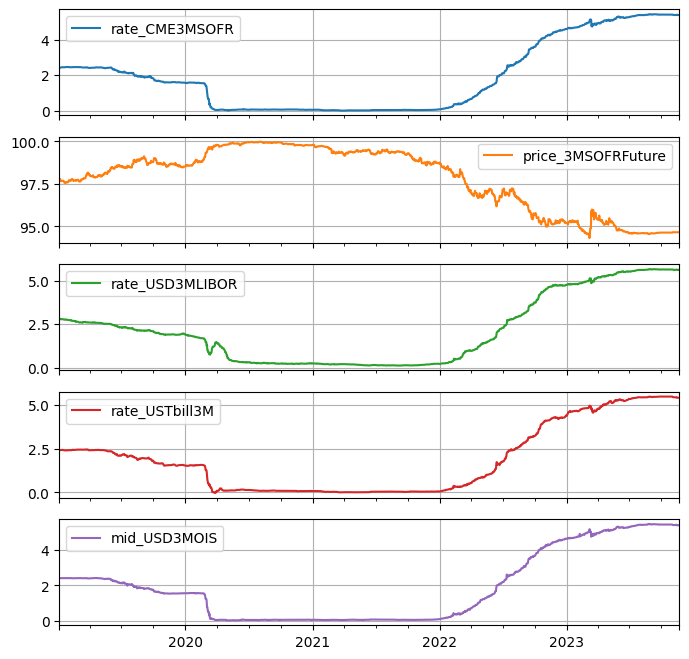

In [18]:
df_concat.iloc[:, 0:].plot(figsize=(8, 8), subplots=True, grid=True)
plt.show()

## Stationary and Diff Check ##

According to https://machinelearningmastery.com/time-series-data-stationary-python/
* p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
* p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

All of our features seem to suggest non-stationarity. Diff by one seems to fix this somewhat

We will reuse some code from ML4T book public github (the plot correlogram)

In [19]:
df_concat["rate_CME3MSOFR"]

2019-01-03    2.43280
2019-01-04    2.42960
2019-01-05    2.42960
2019-01-06    2.42960
2019-01-07    2.42760
               ...   
2023-11-17    5.36710
2023-11-18    5.36710
2023-11-19    5.36710
2023-11-20    5.36710
2023-11-21    5.37151
Freq: D, Name: rate_CME3MSOFR, Length: 1784, dtype: float64

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

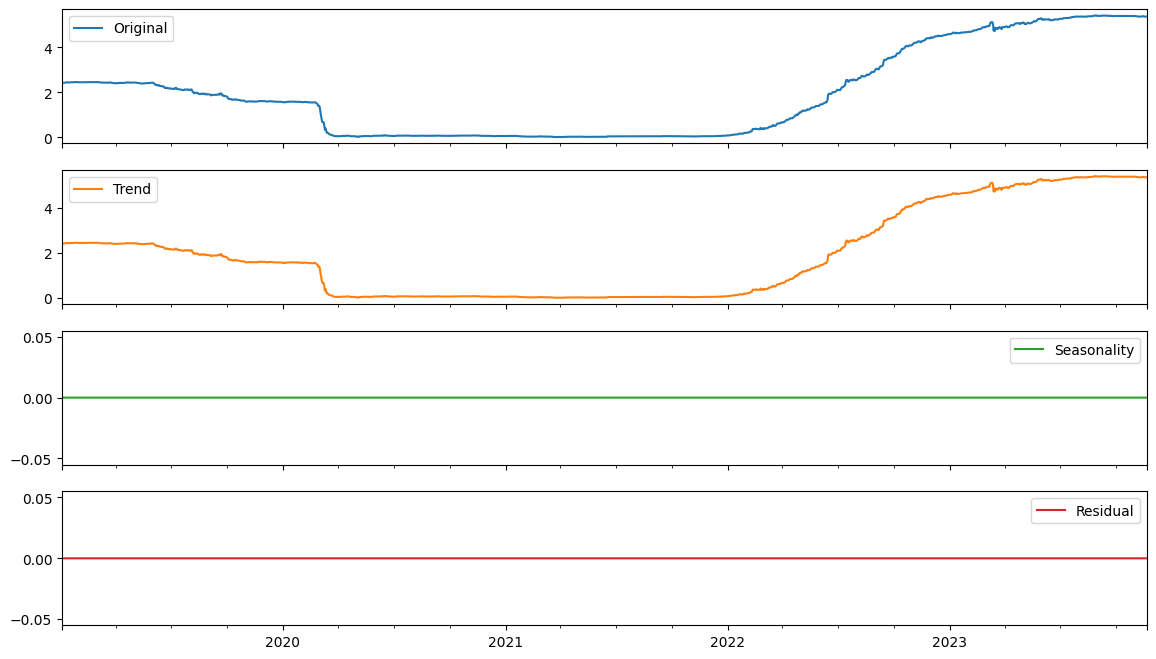

In [20]:
# DECOMPOSE
import statsmodels.tsa.api as tsa

# daily data tho
season_period = 1

components = tsa.seasonal_decompose(
    df_concat["rate_CME3MSOFR"], model="additive", period=season_period
)
ts = (
    df_concat["rate_CME3MSOFR"]
    .to_frame("Original")
    .assign(Trend=components.trend)
    .assign(Seasonality=components.seasonal)
    .assign(Residual=components.resid)
)
ts.plot(subplots=True, figsize=(14, 8))

In [21]:
test_unit_root(df_concat)

{'p_value': {'rate_CME3MSOFR': 0.9133665926618231,
  'price_3MSOFRFuture': 0.2160429622440475,
  'rate_USD3MLIBOR': 0.9766430797241178,
  'rate_USTbill3M': 0.9289140075221823,
  'mid_USD3MOIS': 0.8889570626824697},
 'lag_used': {'rate_CME3MSOFR': 21,
  'price_3MSOFRFuture': 6,
  'rate_USD3MLIBOR': 11,
  'rate_USTbill3M': 14,
  'mid_USD3MOIS': 23}}

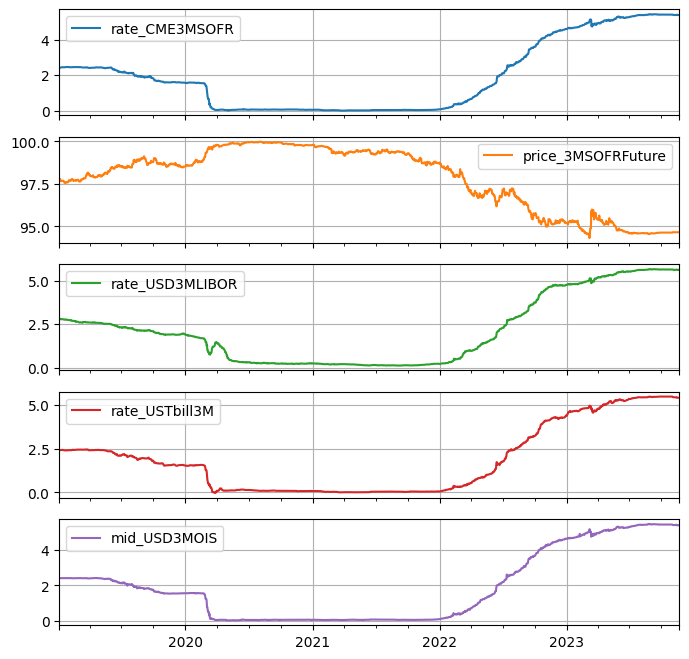

,rate_CME3MSOFR,price_3MSOFRFuture,rate_USD3MLIBOR,rate_USTbill3M,mid_USD3MOIS
2019-01-03,2.43280,97.8350,2.79500,2.3919,2.3930
2019-01-04,2.42960,97.7700,2.80388,2.4058,2.4040
2019-01-05,2.42960,97.7700,2.80388,2.4058,2.4040
2019-01-06,2.42960,97.7700,2.80388,2.4058,2.4040
2019-01-07,2.42760,97.7250,2.79681,2.4127,2.4070
...,...,...,...,...,...
2023-11-17,5.36710,94.6525,5.62854,5.3969,5.3696
2023-11-18,5.36710,94.6525,5.62854,5.3969,5.3696
2023-11-19,5.36710,94.6525,5.62854,5.3969,5.3696
2023-11-20,5.36710,94.6525,5.62854,5.3969,5.3696


In [22]:
# try cut the data for prediction
df_concat.iloc[:, 0:].plot(figsize=(8, 8), subplots=True, grid=True)
plt.show()
df_concat

{'p_value': {'rate_CME3MSOFR': 0.9133665926618231, 'price_3MSOFRFuture': 0.2160429622440475, 'rate_USD3MLIBOR': 0.9766430797241178, 'rate_USTbill3M': 0.9289140075221823, 'mid_USD3MOIS': 0.8889570626824697}, 'lag_used': {'rate_CME3MSOFR': 21, 'price_3MSOFRFuture': 6, 'rate_USD3MLIBOR': 11, 'rate_USTbill3M': 14, 'mid_USD3MOIS': 23}}
{'p_value': {'rate_CME3MSOFR': 1.0744279902030203e-25, 'price_3MSOFRFuture': 1.2898926439065914e-26, 'rate_USD3MLIBOR': 1.6948877362430292e-24, 'rate_USTbill3M': 3.006602860701303e-27, 'mid_USD3MOIS': 1.997951064136983e-26}, 'lag_used': {'rate_CME3MSOFR': 21, 'price_3MSOFRFuture': 25, 'rate_USD3MLIBOR': 25, 'rate_USTbill3M': 16, 'mid_USD3MOIS': 21}}


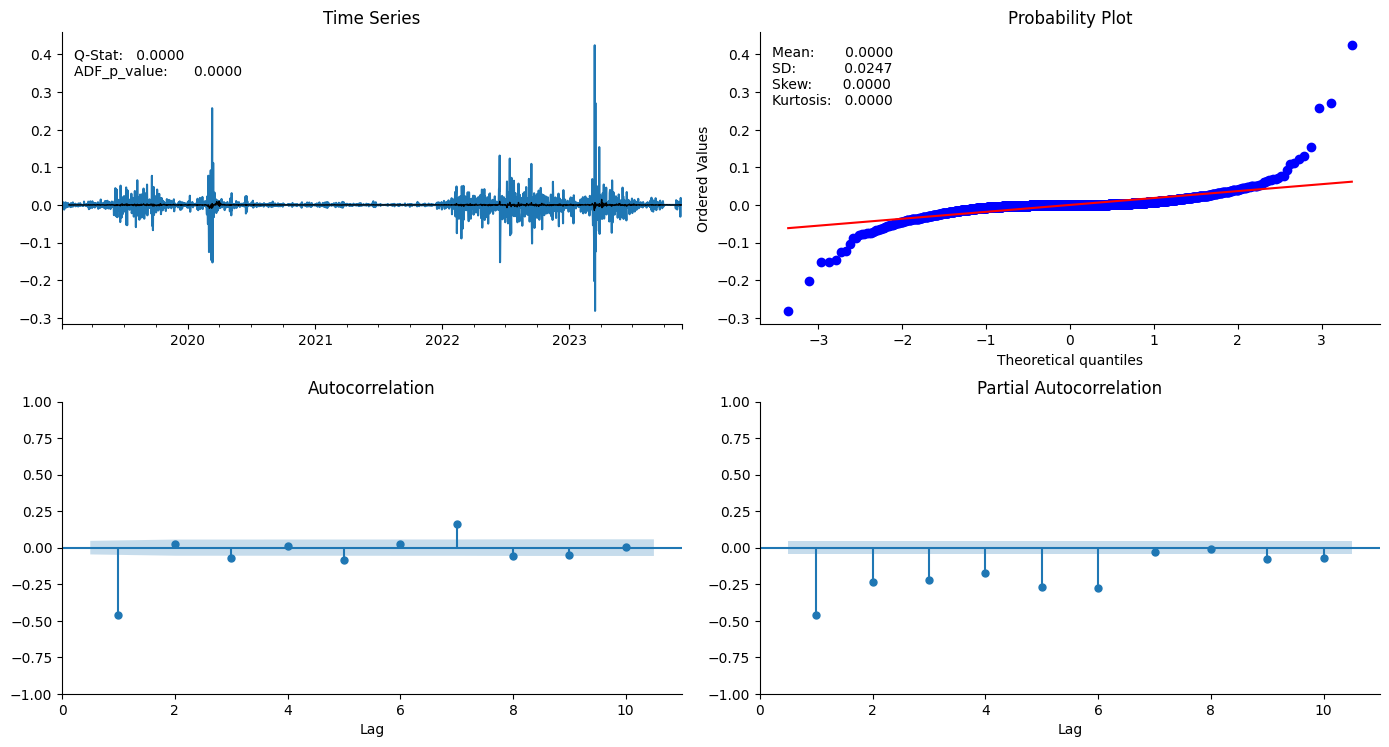

In [23]:
# diff with the exact previous row, 2 order diff !
df_concat_transform = df_concat.diff().diff().dropna()


print(test_unit_root(df_concat))
print(test_unit_root(df_concat_transform))
plot_correlogram(df_concat_transform["rate_CME3MSOFR"])

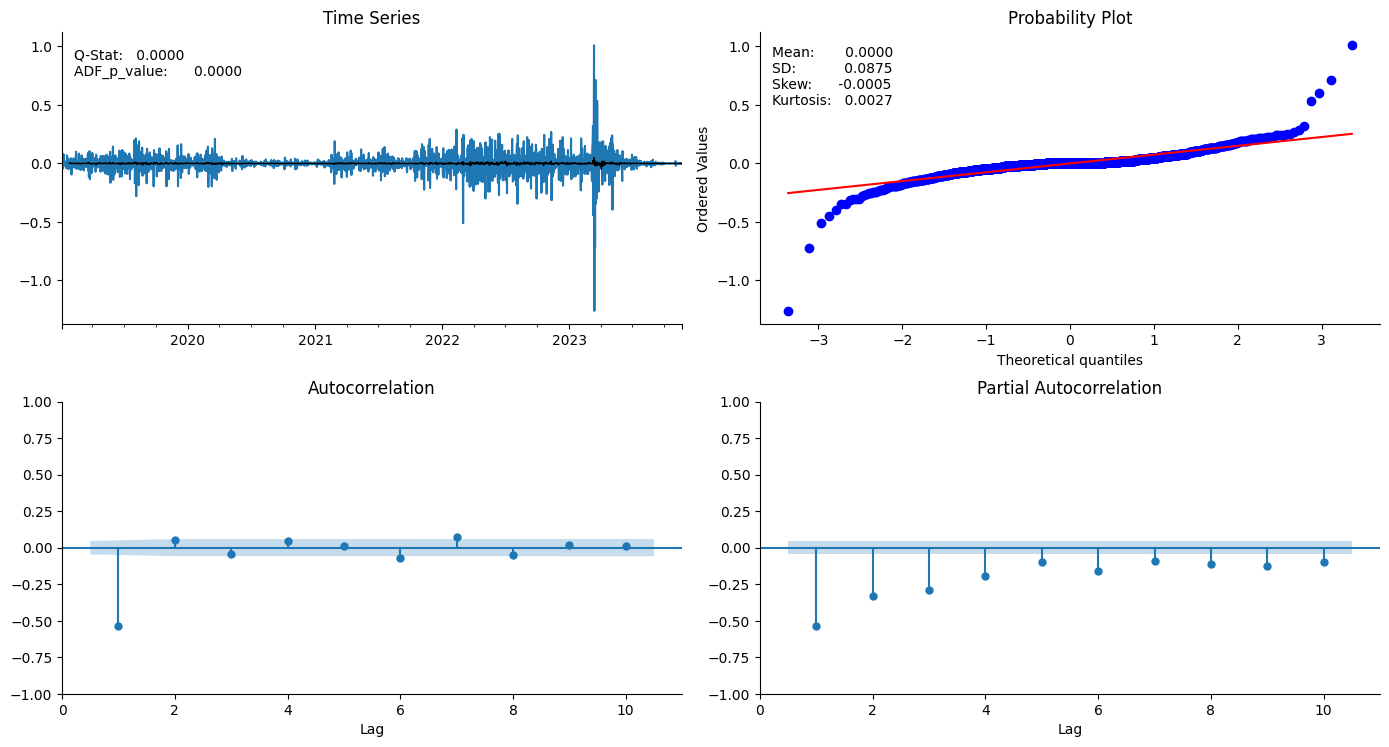

In [24]:
plot_correlogram(df_concat_transform["price_3MSOFRFuture"])

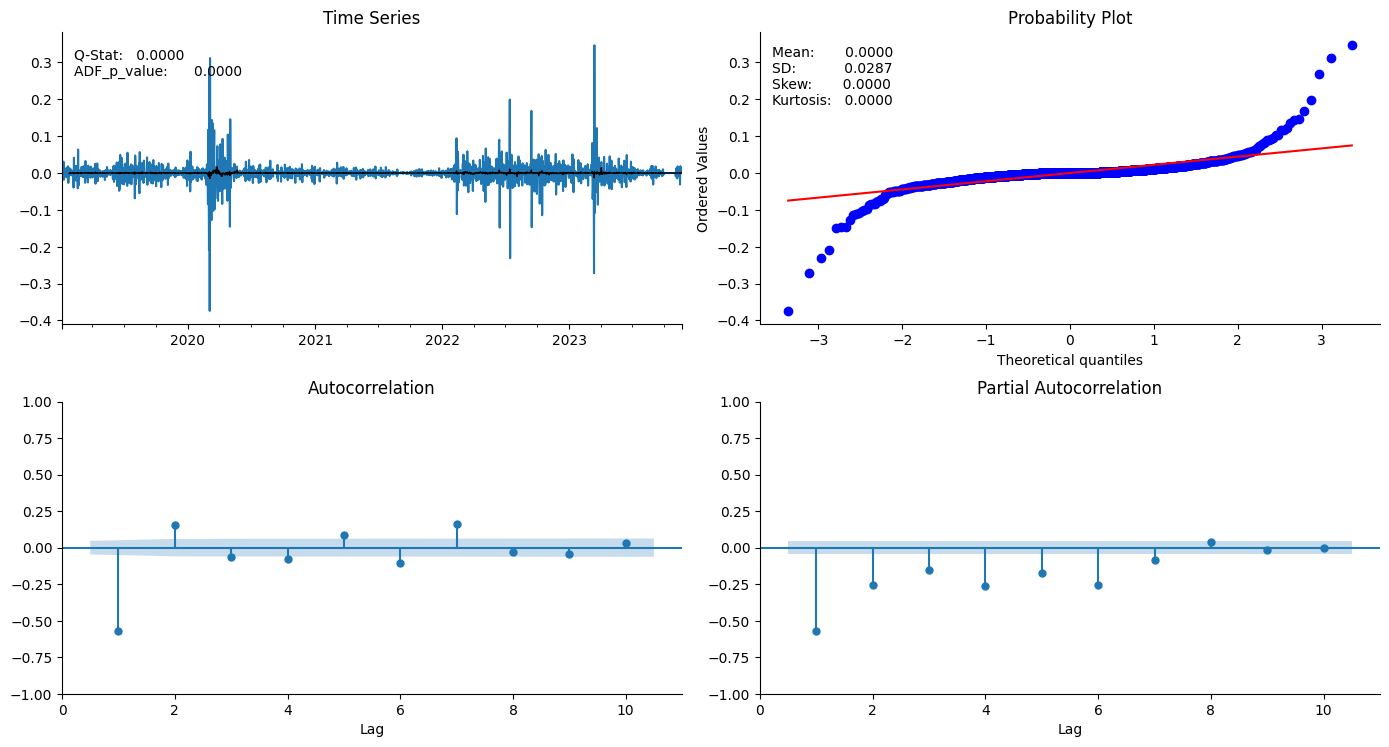

In [25]:
plot_correlogram(df_concat_transform["rate_USD3MLIBOR"])

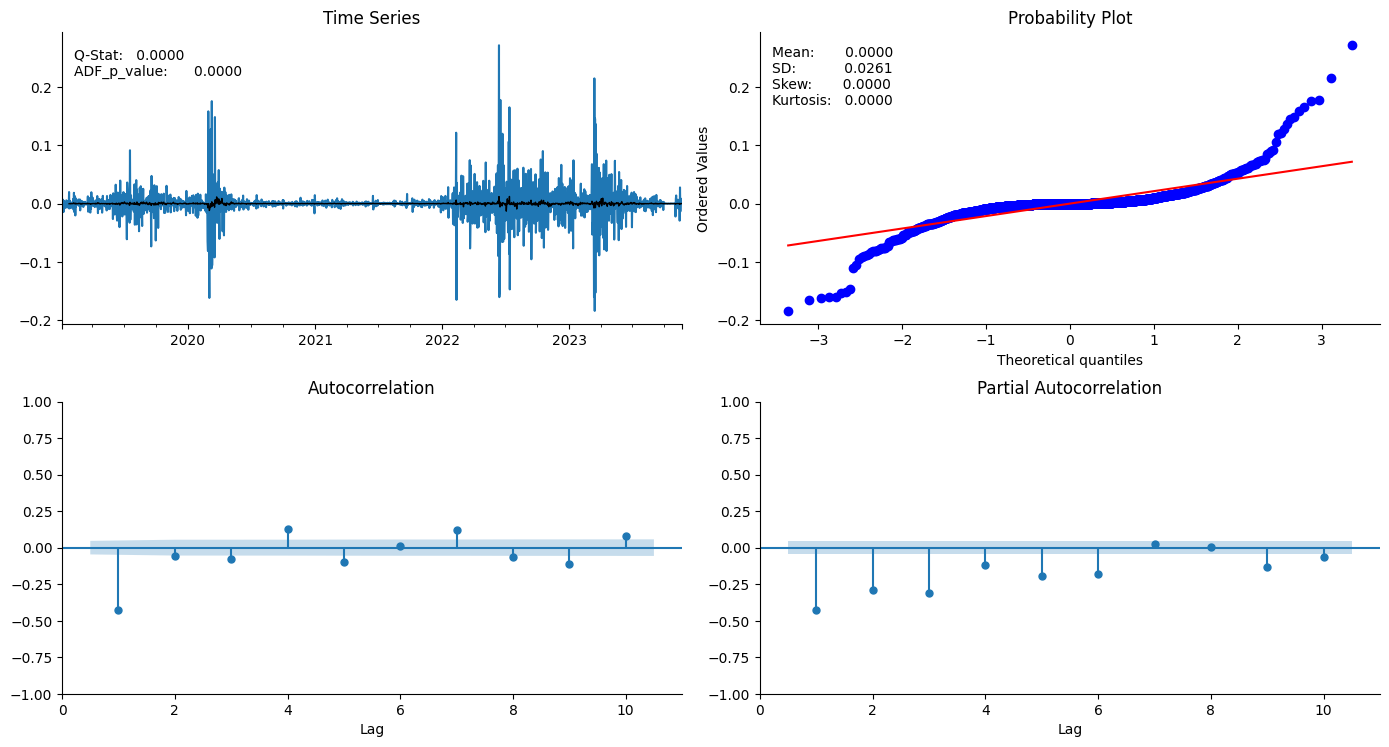

In [26]:
plot_correlogram(df_concat_transform["rate_USTbill3M"])

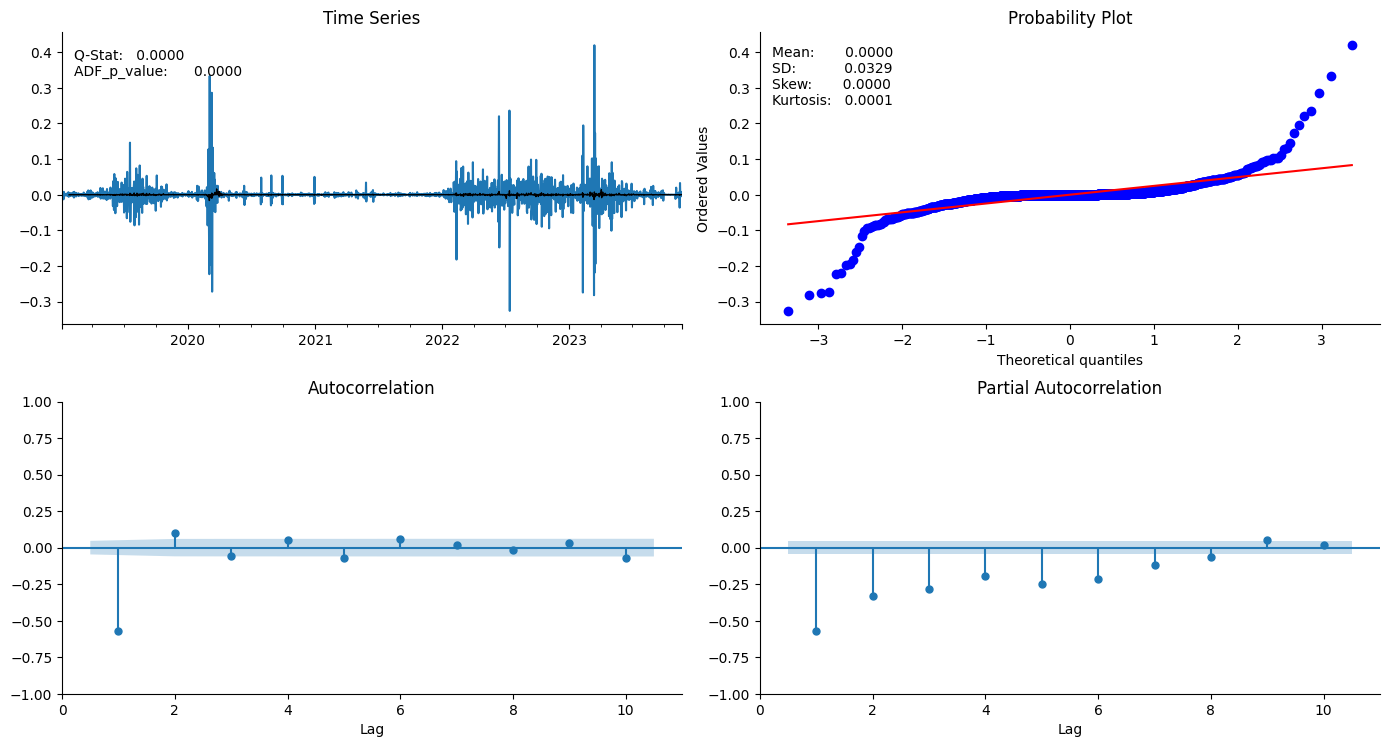

In [27]:
plot_correlogram(df_concat_transform["mid_USD3MOIS"])

In [28]:
df_concat_transform = df_concat_transform.apply(minmax_scale)
df_concat_transform.head(10)

,rate_CME3MSOFR,price_3MSOFRFuture,rate_USD3MLIBOR,rate_USTbill3M,mid_USD3MOIS
2019-01-05,0.403510,0.583700,0.506799,0.373578,0.422705
2019-01-06,0.398977,0.555066,0.519121,0.403981,0.437466
2019-01-07,0.396145,0.535242,0.509311,0.419073,0.441492
2019-01-08,0.404926,0.544053,0.509075,0.414261,0.444176
2019-01-09,0.408892,0.590308,0.561706,0.372047,0.420021
2019-01-10,0.398836,0.548458,0.493700,0.414698,0.448202
2019-01-11,0.381414,0.563877,0.508450,0.397638,0.429415
2019-01-12,0.403651,0.548458,0.532483,0.406168,0.441492
2019-01-13,0.398977,0.555066,0.519121,0.403981,0.437466
2019-01-14,0.395436,0.552863,0.507507,0.406605,0.436125


## TRIAL MODELS ##

In [30]:
# trial order 1,1. Recall trend='n' meaning above
model = VARMAX(df_concat_transform, order=(1, 1), trend="n").fit(maxiter=1000)



print(model.summary())

c:\Users\kilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\kilo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                                                 Statespace Model Results                                                                
Dep. Variable:     ['rate_CME3MSOFR', 'price_3MSOFRFuture', 'rate_USD3MLIBOR', 'rate_USTbill3M', 'mid_USD3MOIS']   No. Observations:                 1782
Model:                                                                                                VARMA(1,1)   Log Likelihood               18056.552
Date:                                                                                           Tue, 28 Nov 2023   AIC                         -35983.105
Time:                                                                                                   01:27:37   BIC                         -35626.548
Sample:                                                                                               01-05-2019   HQIC                        -35851.419
                                                                            

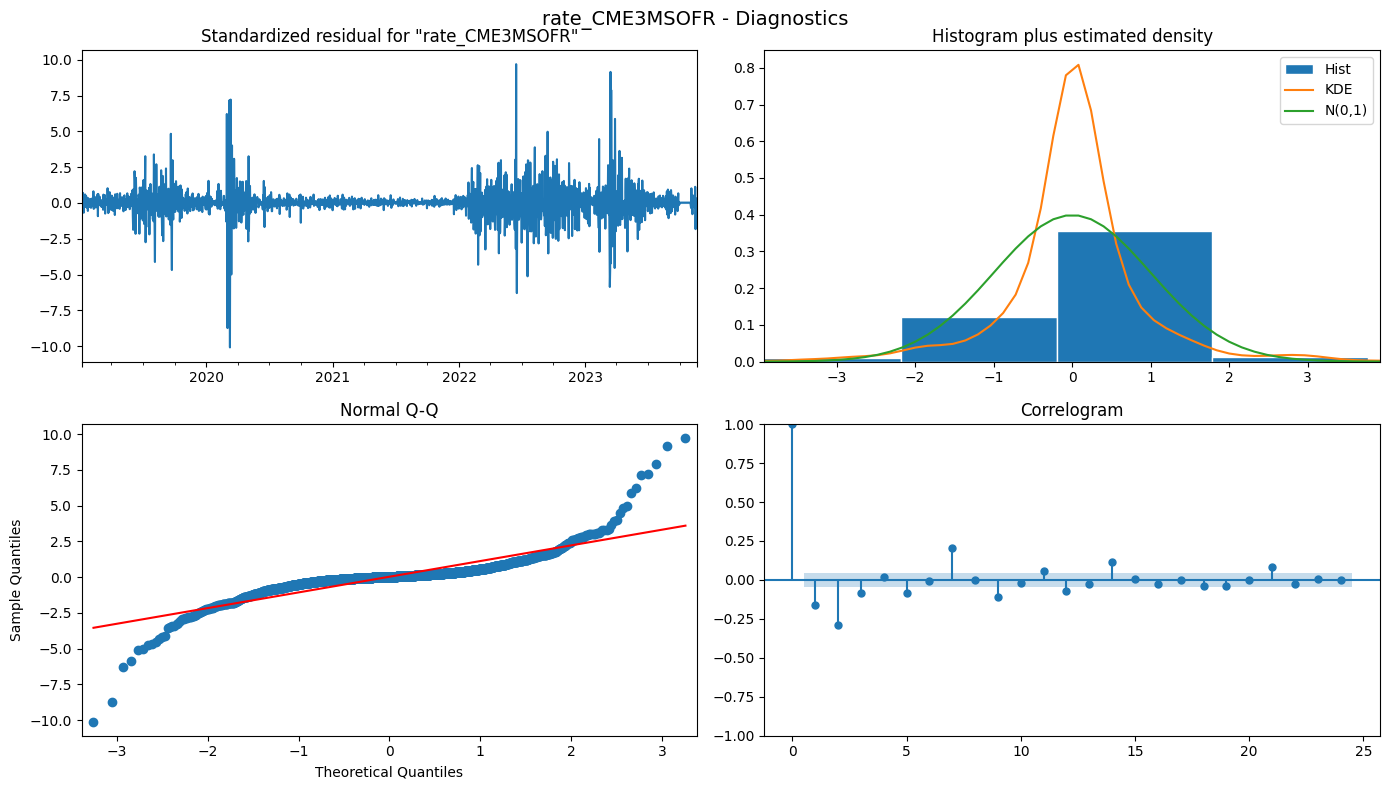

In [31]:
model.plot_diagnostics(variable=0, figsize=(14, 8), lags=24)
plt.gcf().suptitle("rate_CME3MSOFR - Diagnostics", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.93)

In [56]:
n = 770
print(n)
start = n - 100

preds = model.predict(start=start + 1, end=n)
preds.index = range(start, n)

770


<Axes: >

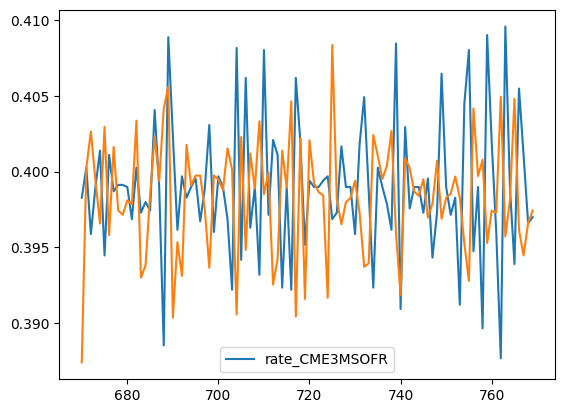

In [59]:
df_concat_transform["rate_CME3MSOFR"].reset_index().drop(columns=["index"]).iloc[
    670:770
].plot()


preds["rate_CME3MSOFR"].plot()

In [ ]:
# trial order 1,1. Recall trend='n' meaning above
model = VARMAX(df_concat_transform, order=(2, 2), trend="n").fit(maxiter=1000)


print(model.summary())